In [1]:

from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q -U keras-tuner


     |████████████████████████████████| 71kB 8.2MB/s 


In [3]:
# Import required packages, libraries and classes for the project

import numpy as np
np.random.seed(1)

import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
from keras.layers import InputLayer, ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.optimizers import Adam, SGD, Nadam
import keras
import kerastuner as kt
plt.style.use('default')

### Data Preprocessing

In [4]:
# Load the Dataset
df = pd.read_csv("/content/drive/My Drive/stockCATT.csv",parse_dates = True,index_col=0)
df.head()

,Open,High,Low,Volume,SMA,EMA,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH,STOCHD,Close
Date,,,,,,,,,,,,,,,
2014-06-25,246.0,246.0,238.0,1850.0,216.190476,219.641297,34.0,67.266588,17.821782,9.627825,216.6,8.282992e+05,80.952381,85.807656,238.0
2014-06-26,228.0,238.0,228.0,21110.0,214.476190,217.805426,28.0,66.497705,13.461538,9.214435,215.1,9.957417e+05,94.117647,92.156863,236.0
2014-06-30,234.0,234.0,232.0,1500.0,213.142857,215.985969,22.0,64.928560,12.621359,8.756407,213.4,1.147855e+06,82.352941,92.156863,232.0
2014-07-02,224.0,238.0,224.0,17000.0,211.904762,214.384566,34.0,69.584450,14.423077,8.451703,212.2,1.319687e+06,100.000000,98.039216,238.0
2014-07-03,228.0,228.0,228.0,25000.0,210.476190,212.023022,22.0,65.677831,9.615385,7.328948,210.6,1.019886e+06,94.117647,89.705882,228.0


In [5]:
# Correlation Matrix
df.corr()['Close']

Open       0.991557
High       0.997188
Low        0.992472
Volume    -0.056827
SMA        0.966160
EMA        0.973782
MOM        0.182838
RSI        0.369130
ROC        0.231322
MACD       0.318521
BB         0.967725
CHAIKIN    0.017259
STOCH      0.220626
STOCHD     0.222055
Close      1.000000
Name: Close, dtype: float64

In [6]:
df.columns

Index(['Open', 'High', 'Low', 'Volume', 'SMA', 'EMA', 'MOM', 'RSI', 'ROC',
       'MACD', 'BB', 'CHAIKIN', 'STOCH', 'STOCHD', 'Close'],
      dtype='object')

In [7]:
# Extracting the features for the ConvLSTM model
series = df[["Close",	"MOM",	"RSI",	"ROC",	"MACD",	"BB",	"CHAIKIN",	"STOCH"]]
print(series.shape)
series.head()

(1053, 8)


,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2014-06-25,238.0,34.0,67.266588,17.821782,9.627825,216.6,8.282992e+05,80.952381
2014-06-26,236.0,28.0,66.497705,13.461538,9.214435,215.1,9.957417e+05,94.117647
2014-06-30,232.0,22.0,64.928560,12.621359,8.756407,213.4,1.147855e+06,82.352941
2014-07-02,238.0,34.0,69.584450,14.423077,8.451703,212.2,1.319687e+06,100.000000
2014-07-03,228.0,22.0,65.677831,9.615385,7.328948,210.6,1.019886e+06,94.117647


In [8]:
# Normalisation
sc_X = StandardScaler()
series.iloc[:,1:] = sc_X.fit_transform(series.iloc[:,1:])
sc_y = StandardScaler()
series[['Close']] = sc_y.fit_transform(series[['Close']])
series

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2014-06-25,1.293529,2.375617,1.953647,1.651032,1.987497,0.817584,-0.249197,0.659242
2014-06-26,1.246472,1.951390,1.862613,1.226817,1.900549,0.781434,-0.186898,1.034633
2014-06-30,1.152358,1.527163,1.676831,1.145074,1.804211,0.740465,-0.130302,0.699178
2014-07-02,1.293529,2.375617,2.228075,1.320366,1.740123,0.711545,-0.066370,1.202361
2014-07-03,1.058244,1.527163,1.765543,0.852618,1.503973,0.672985,-0.177915,1.034633
...,...,...,...,...,...,...,...,...
2020-05-03,-0.094650,-0.452562,-0.928734,-0.136929,0.169339,0.069283,1.445508,-1.348868
2020-05-04,0.093578,0.042369,0.455086,0.295478,0.344475,0.070488,1.252545,-0.148290
2020-05-05,0.164163,0.678709,1.151631,0.234377,0.411930,0.062053,-0.166717,0.301927


In [9]:
# Train/Test Data Split
train_start = dt.date(2014,5,15)
train_end = dt.date(2020,3,1)
train_data = series.loc[train_start:train_end]

test_start = dt.date(2020,3,2)
test_end = dt.date(2020,6,14)
test_data = series.loc[test_start:test_end]

print(train_data.shape,test_data.shape)

(1006, 8) (47, 8)


In [10]:
train = train_data.values
val = test_data.values

In [11]:
# Setting up an Early Stopping function
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]
RMSE = keras.metrics.RootMeanSquaredError()

In [12]:
X_train = []
Y_train = []
X_val = []
Y_val = []
timesteps = 45

# Loop for training data
for i in range(timesteps,train.shape[0]):
  X_train.append(train[i-timesteps:i])
  Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

# Loop for val data
for i in range(timesteps,val.shape[0]):
  X_val.append(val[i-timesteps:i])
  Y_val.append(val[i][0])
X_val,Y_val = np.array(X_val),np.array(Y_val)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1, X_val.shape[2], 1)

In [13]:
from keras import backend as K
from keras.losses import mean_squared_error

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))

In [14]:
def model_builder(hp):
  # Define the ConvLSTM Model
  model = Sequential()

  # Input shape: (samples, time, channels, rows, cols) see: https://keras.io/layers/recurrent/#convlstm2d
  hp_filter = hp.Choice('filter', values = [8,16,32])
  model.add(ConvLSTM2D(
          filters=hp_filter,
          kernel_size=(10, 10),
          input_shape=(X_train.shape[1], 1, X_train.shape[3], 1),
          padding='same',
          return_sequences=True))
  model.add(LeakyReLU())
  model.add(BatchNormalization())

  model.add(ConvLSTM2D(
          filters=hp_filter,
          kernel_size=(5, 5),
          padding='same',
          return_sequences=False))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  hp_dropout = hp.Float('dropout', min_value = .2, max_value = .5, step = .1)

  model.add(Dropout(rate = hp_dropout))

  model.add(Flatten())

  hp_units = hp.Int('units', min_value = 16, max_value = 64, step = 8)
  model.add(Dense(units=hp_units, kernel_initializer='TruncatedNormal'))
  model.add(LeakyReLU())
  model.add(Dropout(rate = hp_dropout))

  model.add(Dense(units=hp_units, kernel_initializer='TruncatedNormal'))
  model.add(LeakyReLU())
  model.add(Dropout(rate = hp_dropout))

  model.add(Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  hp_batch = hp.Choice('batch_size', values = [8,16,64])

  model.compile(optimizer = optimizers.Adam(learning_rate = hp_learning_rate),
                loss = root_mean_squared_error,
                metrics=[root_mean_squared_error,'mse', 'mae', 'mape'])
  
  return model

In [15]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 50,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

In [16]:
import tensorflow as tf
import IPython
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [17]:
tuner.search(X_train, Y_train, epochs = 10, validation_data = (X_val, Y_val), callbacks = [ClearTrainingOutput()])


Trial 90 Complete [00h 11m 21s]
val_loss: 0.013783164322376251

Best val_loss So Far: 0.0011785179376602173
Total elapsed time: 03h 37m 40s
INFO:tensorflow:Oracle triggered exit


In [18]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete.\nThe optimal number of units in the first densely-connected layer is {best_hps.get('units')}\n
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}\n
The best dropout is {best_hps.get('dropout')}\n
The best batch size is {best_hps.get('batch_size')}\n
The best num of epochs is {best_hps.get('tuner/epochs')}\n
The best num of filters is {best_hps.get('filter')}.
""")


The hyperparameter search is complete.
The optimal number of units in the first densely-connected layer is 64

The optimal learning rate for the optimizer is 0.01

The best dropout is 0.30000000000000004

The best batch size is 16

The best num of epochs is 17

The best num of filters is 16.



In [19]:
tuner.results_summary(num_trials=90)

Results summary
Results in my_dir/intro_to_kt
Showing 90 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filter: 16
dropout: 0.30000000000000004
units: 64
learning_rate: 0.01
batch_size: 16
tuner/epochs: 17
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.0011785179376602173
Trial summary
Hyperparameters:
filter: 8
dropout: 0.30000000000000004
units: 24
learning_rate: 0.01
batch_size: 16
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.013783164322376251
Trial summary
Hyperparameters:
filter: 16
dropout: 0.30000000000000004
units: 64
learning_rate: 0.01
batch_size: 16
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 56f3e763ead6927e846a9c880e49966e
Score: 0.019410520792007446
Trial summary
Hyperparameters:
filter: 16
dropout: 0.5000000000000001
units: 56
learning_rate: 0.01
batch_size: 8
tuner/epochs: 6
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Scor

In [20]:
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, Y_train, epochs = 50, validation_data = (X_val, Y_val))

Epoch 1/50
31/31 [==============================] - 18s 462ms/step - loss: 0.6140 - root_mean_squared_error: 0.6140 - mse: 0.6599 - mae: 0.6140 - mape: 1941.0942 - val_loss: 0.2465 - val_root_mean_squared_error: 0.2465 - val_mse: 0.0613 - val_mae: 0.2465 - val_mape: 95.4112
Epoch 2/50
31/31 [==============================] - 13s 434ms/step - loss: 0.3379 - root_mean_squared_error: 0.3379 - mse: 0.1973 - mae: 0.3379 - mape: 893.8165 - val_loss: 0.2616 - val_root_mean_squared_error: 0.2616 - val_mse: 0.0690 - val_mae: 0.2616 - val_mape: 101.2682
Epoch 3/50
31/31 [==============================] - 13s 434ms/step - loss: 0.3569 - root_mean_squared_error: 0.3569 - mse: 0.2177 - mae: 0.3569 - mape: 663.5954 - val_loss: 0.2070 - val_root_mean_squared_error: 0.2070 - val_mse: 0.0437 - val_mae: 0.2070 - val_mape: 79.7553
Epoch 4/50
31/31 [==============================] - 13s 433ms/step - loss: 0.3933 - root_mean_squared_error: 0.3933 - mse: 0.2720 - mae: 0.3933 - mape: 1094.8400 - val_loss: 0.

In [21]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Close')
    plt.title('Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [22]:
# Plotting the training errors
def plot_loss(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

In [23]:
# Evaluating the model
def evaluate_model(model,X_val):
     # Prediction Time 
    Y_hat = model.predict(X_val)
    return Y_val, Y_hat
  

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 45, 1, 8, 16)      108864    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 45, 1, 8, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 45, 1, 8, 16)      64        
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 8, 16)          51264     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1, 8, 16)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 8, 16)          64        
_________________________________________________________________
dropout (Dropout)            (None, 1, 8, 16)          0

In [25]:
y_pred = model.predict(X_val)
y_true = np.array([Y_val]).T

mae = tf.keras.losses.MeanAbsoluteError()
mae = mae(y_true, y_pred).numpy()

mape = tf.keras.losses.MeanAbsolutePercentageError()
mape = mape(y_true, y_pred).numpy()

mse = tf.keras.losses.MeanSquaredError()
mse = mse(y_true, y_pred).numpy()

rmse = sqrt(mse)


In [1]:
print('MSE = {}'.format(round(mse, 5)))
print('RMSE = {}'.format(round(rmse, 5)))
print('MAPE = {}'.format(round(mape, 5)))
print('MAE = {}'.format(round(mae, 5)))

NameError: ignored

In [27]:
true ,predicted = evaluate_model(model,X_val)

In [28]:
train_date = df['2014-05-15' : '2020-03-1'].index
test_date = df['2020-03-2' :].index
pred_date = df['2020-03-2' :].index[45:]

In [29]:
Y_train = sc_y.inverse_transform(np.array([train[:,0]]))
Y_test = sc_y.inverse_transform(np.array([val[:,0]]))
Y_pred = sc_y.inverse_transform(predicted.T)

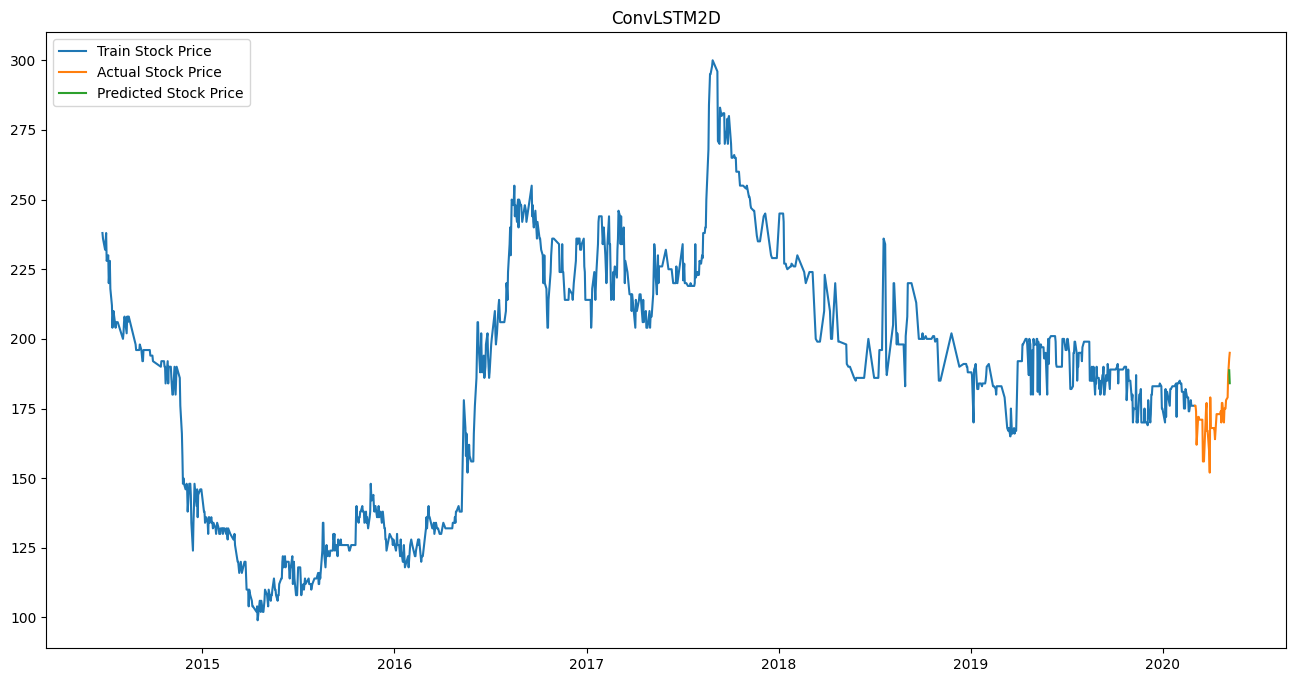

In [30]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

plt.figure(figsize=(16,8))
price_close_train = Y_train[0]
price_close_test = Y_test[0]
plt.plot(train_date, price_close_train, label = "Train Stock Price")
plt.plot(test_date, price_close_test, label = "Actual Stock Price")
plt.plot(pred_date, Y_pred[0], label = "Predicted Stock Price")

plt.title("ConvLSTM2D")
plt.legend(loc='upper left')
#plt.tight_layout()

plt.show()

In [31]:
# Save a model
model.save('ConvLSTM2D_dataset1.h5')